### A DS framework

- **Define the Problem**: what is the problem we are solving? Too often we are quick to jump on the new shiny technology, tool, or algorithm before determining the actual problem we are trying to solve. Begin with the decision-maker from the business! Define success! https://hackernoon.com/the-first-step-in-ai-might-surprise-you-cbd17a35708a. It can be that plain analytics is a better fit for you. AI applied wrongly: all the right math and data to solve the wrong problem. oeps..

- **Gather the Data**: it may be external or internal, structured or unstructured, static or streamed, objective or subjective, etc. 

- **Prepare Data for Consumption**: data wrangling/ munging, turn into “manageable” data. Data wrangling includes implementing data architectures for storage and processing, developing data governance standards for quality and control, data extraction (i.e. ETL and web scraping), and data cleaning to identify aberrant, missing, or outlier data points.

- **Perform Exploratory Analysis - EDA**: garbage-in, garbage-out (GIGO). Therefore, it is important to deploy descriptive and graphical statistics to look for potential problems, patterns, classifications, correlations and comparisons in the dataset. In addition, data categorization (i.e. qualitative vs quantitative) is also important to understand and select the correct hypothesis test or data model.

- **Model Data**: Like descriptive and inferential statistics, data modeling can either summarize the data or predict future outcomes. Your dataset and expected results, will determine the algorithms available for use. 

- **Validate and Implement Data Model**: After training on a subset, we need testing to determine if our model overfits, generalizes, or underfits our dataset.

- **Optimize and Strategize**: iterate back through the process to make it better. As a data scientist, your strategy should be to outsource developer operations and application plumbing, so you have more time to focus on recommendations and design. Once you're able to package your ideas, this becomes your “currency exchange" rate.

In [41]:
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#path
path_data = 'data/'

import sys
print('Python: {}'.format(sys.version))

Python: 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


In [2]:
df_train = pd.read_csv(path_data + 'houseprices_train.csv', header=0)

In [3]:
#descriptive statistics summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

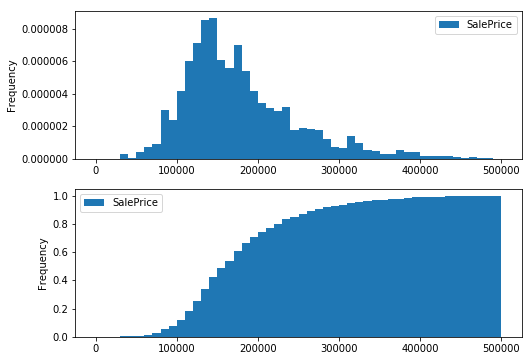

In [9]:
# histogram subplot with non cumulative and cumulative
fig, ax = plt.subplots(2,1, figsize=[8,6])
df_train.plot(kind = "hist",y = 'SalePrice', bins = 50,range= (0,500000), density = True,ax = ax[0])
df_train.plot(kind = "hist",y = 'SalePrice', bins = 50,range= (0,500000),density = True,ax = ax[1],cumulative = True)

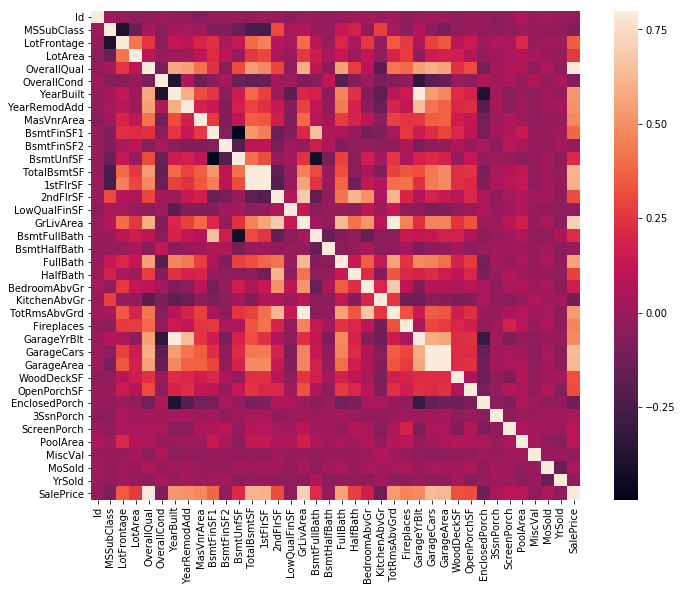

In [36]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

two red colored squares: 1) 'TotalBsmtSF' and '1stFlrSF' variables, and 2nd: 'GarageX' variables. Both cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs. Heatmaps are great to detect this kind of situations and in problems dominated by feature selection, like ours, they are an essential tool.

Another thing that got my attention was the 'SalePrice' correlations. We can see our well-known 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' saying a big 'Hi!', but we can also see many other variables that should be taken into account. That's what we will do next.

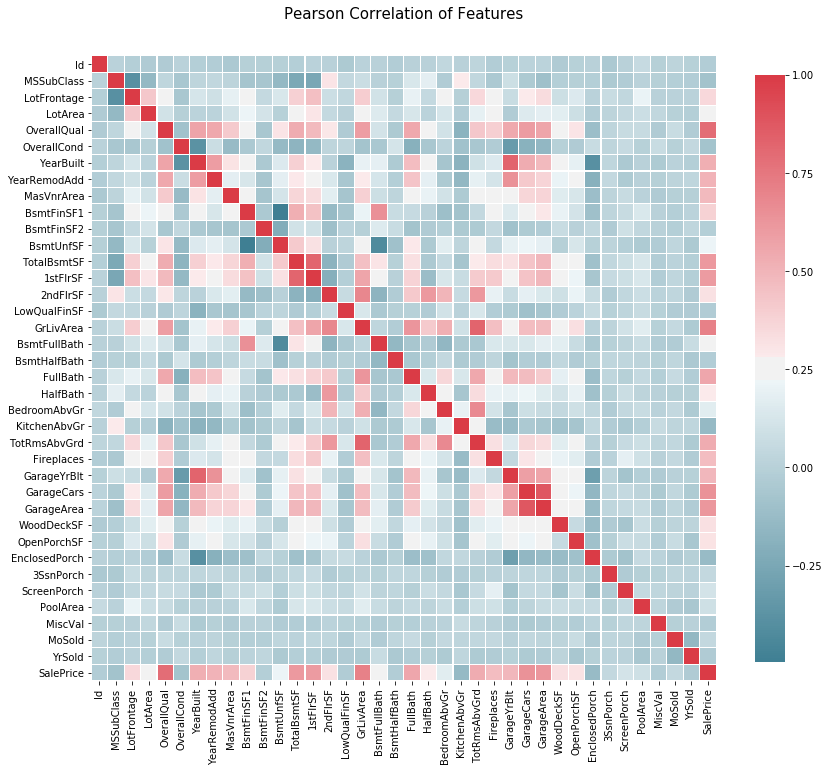

In [37]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=False, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':8 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df_train)

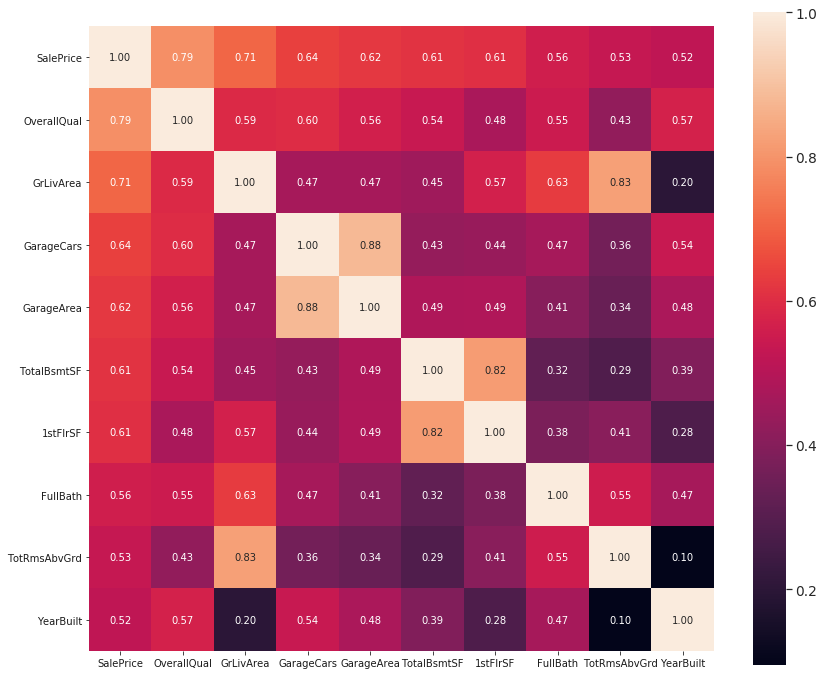

In [38]:
#saleprice correlation matrix
_ , ax = plt.subplots(figsize =(14, 12))
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', ax=ax,
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)


According to our crystal ball, these are the variables most correlated with 'SalePrice'. My thoughts on this:

- 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. Check!
- 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
- 'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF' just to say that our first guess was right (re-read 'So... What can we expect?').
- 'FullBath'?? Really?
- 'TotRmsAbvGrd' and 'GrLivArea', twin brothers again. Is this dataset from Chernobyl?
- Ah... 'YearBuilt'... It seems that 'YearBuilt' is slightly correlated with 'SalePrice'. Honestly, it scares me to think about 'YearBuilt' because I start feeling that we should do a little bit of time-series analysis to get this right. I'll leave this as a homework for you.

Let's proceed to the scatter plots.

In [39]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


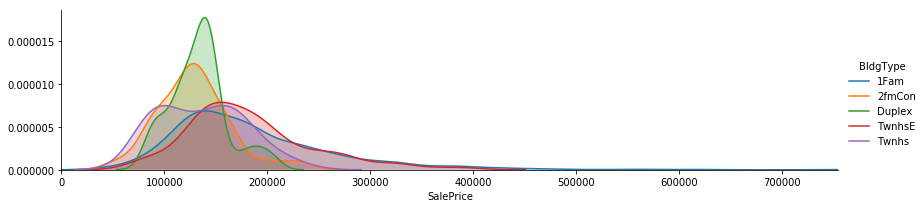

In [28]:
#plot distributions 
a = sns.FacetGrid(df_train, hue = 'BldgType', aspect=4)
a.map(sns.kdeplot, 'SalePrice', shade= True )
a.set(xlim=(0 , df_train['SalePrice'].max()))
a.add_legend()

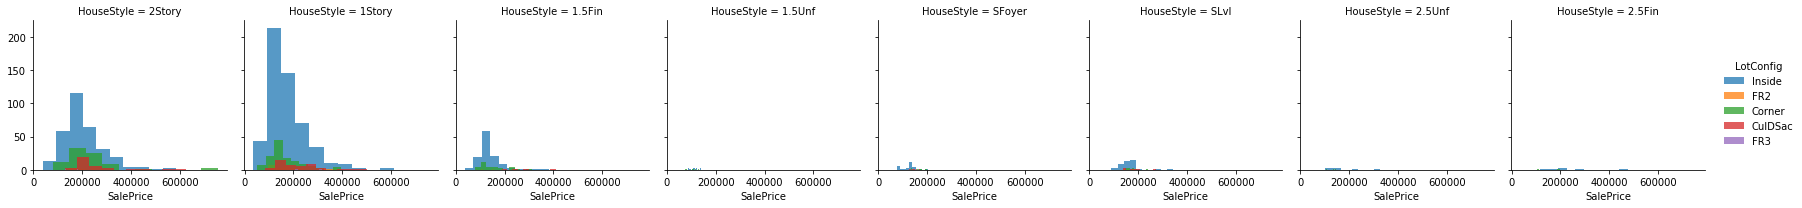

In [31]:
#histogram comparison 
h = sns.FacetGrid(df_train, col = 'HouseStyle', hue = 'LotConfig')
h.map(plt.hist, 'SalePrice', alpha = .75)
h.add_legend()

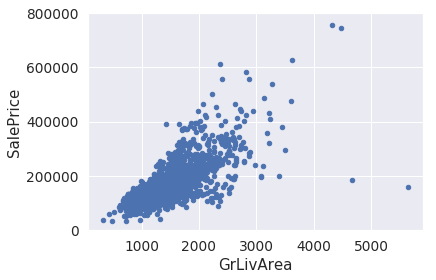

In [23]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [25]:
from sklearn.preprocessing import StandardScaler
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


/home/diederik/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


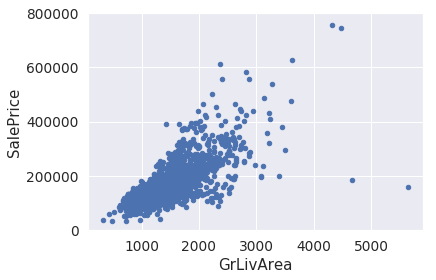

In [26]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [27]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

Now it's time to go deep and understand how 'SalePrice' complies with the statistical assumptions that enables us to apply multivariate techniques.

According to Hair et al. (2013), four assumptions should be tested:

- **Normality** - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

- **Homoscedasticity** - I just hope I wrote it right. Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

- **Linearity**- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

- **Absence of correlated errors** - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

### In the search for normality

/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


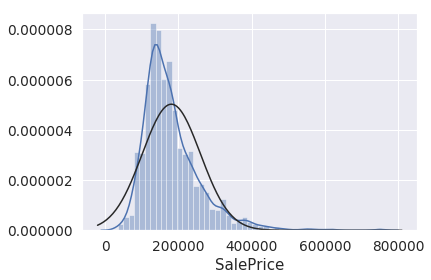

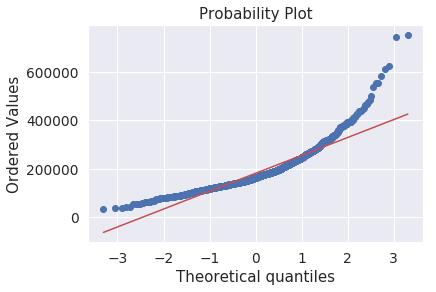

In [42]:
from scipy.stats import norm
from scipy import stats
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Ok, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

But everything's not lost. A simple data transformation can solve the problem. This is one of the awesome things you can learn in statistical books: in case of positive skewness, log transformations usually works well. When I discovered this, I felt like an Hogwarts' student discovering a new cool spell.

In [43]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


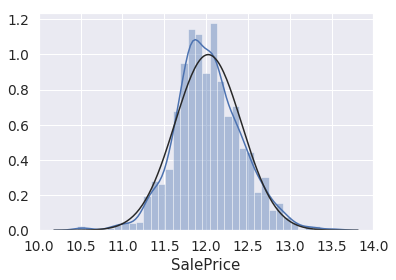

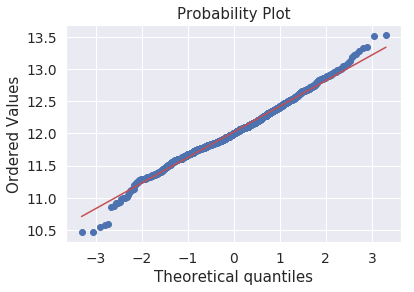

In [44]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

GrLivArea

/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


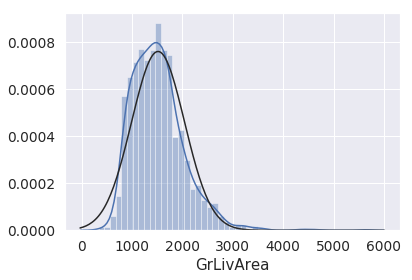

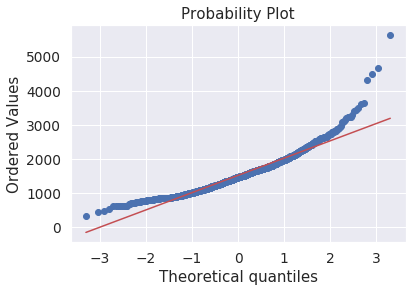

In [45]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [46]:
#data transformation to get rid of skewness
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


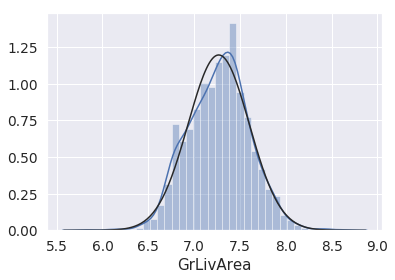

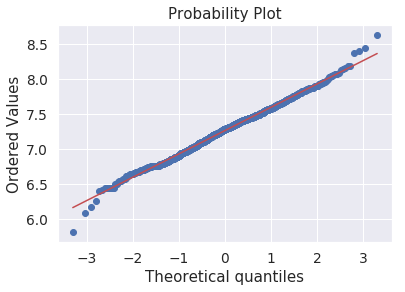

In [47]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


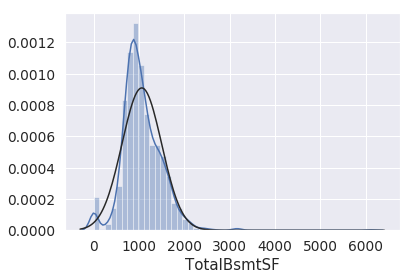

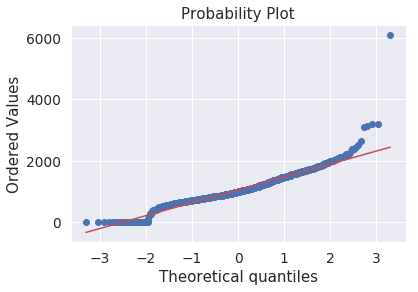

In [48]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

Ok, now we are dealing with the big boss. What do we have here?

Something that, in general, presents skewness.
A significant number of observations with value zero (houses without basement).
A big problem because the value zero doesn't allow us to do log transformations.
To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

I'm not sure if this approach is correct. It just seemed right to me. That's what I call 'high risk engineering'.

In [49]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

/home/diederik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


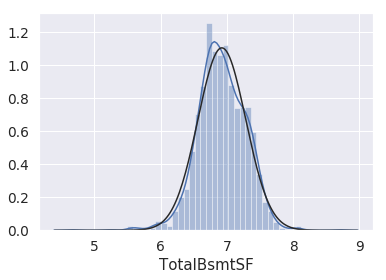

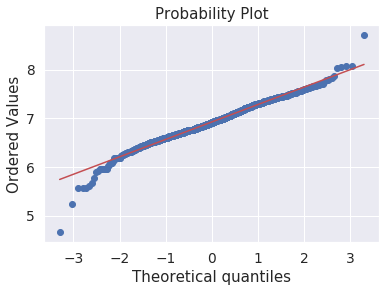

In [50]:
#histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

### In the search for writing 'homoscedasticity' right at the first attempt¶

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

Starting by 'SalePrice' and 'GrLivArea'...

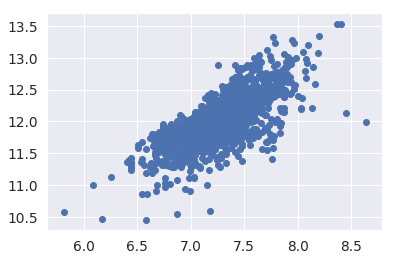

In [51]:
#scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

Older versions of this scatter plot (previous to log transformations), had a conic shape (go back and check 'Scatter plots between 'SalePrice' and correlated variables (move like Jagger style)'). As you can see, the current scatter plot doesn't have a conic shape anymore. That's the power of normality! Just by ensuring normality in some variables, we solved the homoscedasticity problem.

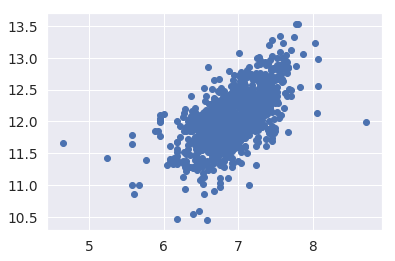

In [52]:
#scatter plot
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

In [53]:
# Model selection